##### Implement a Linear Classifier of form f = Wx, using an SVM loss function and weights updated by stochastic gradient descent

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
import skimage.io as io
from skimage.transform import resize
sys.path.append('../')
import nn.linear_classifier as LC
import helpers.histogram_classifier as hc
from imp import reload
import time

In [2]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
SIZE = 64

In [4]:
classes = pd.read_csv('../data/food-101/meta/top_classes.csv', index_col=0)
class_list = list(classes['class'].unique())

image_names = {}
for c in class_list:
    image_names[c] = np.array(classes[classes['class'] == c]['name'])

In [5]:
# Load the images, and rescale to smaller size
X = []
y = []
for i, c in enumerate(class_list):
    for im_name in image_names[c]:
        im = io.imread(os.path.join("../data/food-101/top_classes/", c, "", im_name))
        im = resize(im, (SIZE, SIZE, SIZE, 3))
        X.append(im)
        y.append(i)

In [6]:
# Convert X and y to numpy arrays for ease of use
X = np.array(X)
y = np.array(y)
print("X has shape: {}".format(X.shape))
print("y has shape: {}".format(y.shape))

X has shape: (12000, 64, 64, 3)
y has shape: (12000,)


In [7]:
# Split X and y into training and test data
# Further create a small sub-set of the training data for code development
n_train = int(np.floor(0.85 * X.shape[0]))
all_indices = np.arange(0, X.shape[0])
np.random.shuffle(all_indices)
train, test = all_indices[:n_train], all_indices[n_train:]

X_train = X[train]
y_train = y[train]
X_test = X[test]
y_test = y[test]

mask = np.random.choice(n_train, 200, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

print("X_train has shape: {}".format(X_train.shape))
print("y_train has shape: {}".format(y_train.shape))
print("X_test has shape: {}".format(X_test.shape))
print("y_test has shape: {}".format(y_test.shape))
print("X_dev has shape: {}".format(X_dev.shape))
print("y_dev has shape: {}".format(y_dev.shape))

X_train has shape: (10200, 64, 64, 3)
y_train has shape: (10200,)
X_test has shape: (1800, 64, 64, 3)
y_test has shape: (1800,)
X_dev has shape: (200, 64, 64, 3)
y_dev has shape: (200,)


In [8]:
# Reshape the X data
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print("X_train has shape: {}".format(X_train.shape))
print("X_test has shape: {}".format(X_test.shape))
print("X_dev has shape: {}".format(X_dev.shape))

X_train has shape: (10200, 12288)
X_test has shape: (1800, 12288)
X_dev has shape: (200, 12288)


In [9]:
# Subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# Append bias dimension of ones to simplify the optimization procedure
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print("X_train has shape: {}".format(X_train.shape))
print("X_test has shape: {}".format(X_test.shape))
print("X_dev has shape: {}".format(X_dev.shape))

X_train has shape: (10200, 12289)
X_test has shape: (1800, 12289)
X_dev has shape: (200, 12289)


In [11]:
%%time
# Do some cross validation for learning rate and regularization weight
learning_rates = [1e-7, 1e-6, 1e-5, 1e-4]
reg_weights = [0.01, 0.1, 1, 10]

results = {}
best_score = -1   # The highest validation accuracy that we have seen so far.
best_params = (0,0)

for l in learning_rates:
    for r in reg_weights:
        #Get some training and validation data
            n_train = int(np.floor(0.85 * X_train.shape[0]))
            mask = np.arange(0, X_train.shape[0])
            np.random.shuffle(mask)
            X_t = X_train[mask[:n_train]]
            X_val = X_train[mask[n_train:]]
            y_t = y_train[mask[:n_train]]
            y_val = y_train[mask[n_train:]]
            svm = LC.LinearSVM()
            losses = svm.fit(X_t, y_t, learning_rate=l, lam=r, num_iterations=3000)
            predictions = svm.predict(X_val)
            score = np.mean(predictions == y_val)
            results[(l, r)] = score
            if score > best_score:
                best_score = score
                best_params = (l, r)

print("Best result: {}".format(best_score))
print("Learning rate: {}, Regularization factor: {}".format(best_params[0], best_params[1]))

Best result: 0.24640522875816995
Learning rate: 0.0001, Regularization factor: 0.1
CPU times: user 26min 33s, sys: 3min 50s, total: 30min 23s
Wall time: 15min 44s


In [22]:
best_params

(0.0001, 0.1)

In [12]:
svm = LC.LinearSVM()

In [13]:
start = time.time()
losses = svm.fit(X_train, y_train, learning_rate = best_params[0], lam = best_params[1], num_iterations=60000, verbose=False)
end = time.time()
print ('That took %fs' % (end - start))

That took 1152.856458s


In [14]:
plt.style.use('seaborn-pastel')

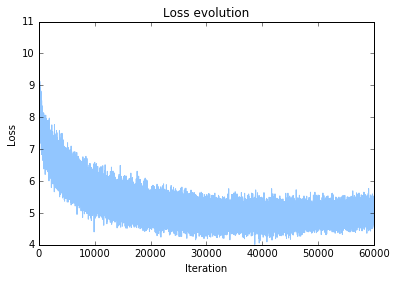

In [15]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss evolution")
plt.show()

In [16]:
predictions = svm.predict(X_test)

In [17]:
def get_class(x):
    return class_list[x]

get_class = np.vectorize(get_class)

In [18]:
overall, metrics, confusion = hc.get_metrics(get_class(y_test), get_class(predictions), class_list)

In [19]:
overall

,Accuracy,F1,Precision,Recall
Results,0.234,0.232,0.232,0.234


In [20]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.22,0.23,0.22,149.0
lasagna,0.23,0.22,0.22,160.0
french_toast,0.12,0.08,0.09,165.0
guacamole,0.48,0.46,0.47,163.0
apple_pie,0.13,0.14,0.13,137.0
cheesecake,0.15,0.17,0.16,150.0
hamburger,0.16,0.17,0.16,138.0
fried_rice,0.26,0.24,0.25,164.0
carrot_cake,0.22,0.18,0.20,158.0
chocolate_cake,0.32,0.38,0.34,133.0


In [21]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,34,7,6,6,6,11,16,6,11,16,24,6
lasagna,14,35,13,7,19,12,11,12,3,3,8,23
french_toast,8,26,13,8,22,18,15,9,13,16,8,9
guacamole,4,6,1,75,4,5,16,21,6,4,6,15
apple_pie,8,12,17,7,19,15,12,13,6,10,4,14
cheesecake,13,5,12,7,15,26,6,12,14,19,13,8
hamburger,12,7,7,7,18,6,23,12,8,5,18,15
fried_rice,12,22,9,14,13,6,14,40,10,9,4,11
carrot_cake,12,7,9,9,13,25,12,10,28,8,15,10
chocolate_cake,12,6,7,4,3,18,3,3,13,50,12,2
